# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [126]:
#Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.layers import BatchNormalization
import joblib


# **The Dataset**
**Problem Statement**
Existing fashion recommendation systems lack deep personalization, leading to poor outfit suggestions and decision fatigue. This project aims to develop a machine-learning model that classifies fashion items based on key attributes to enhance personalized recommendations.


The dataset is s**yntethic genereted data using pandas**, due to unavailablity of existing non-generic dataset that algin the puporse of my model. It contains 10,000 samples with features like material type, color brightness, price, season, and comfort level, correlated with five fashion categories (Casual, Formal, Sportswear, Partywear, Traditional).

In [127]:
# Generating Dataset

# Set seed for reproducibility
np.random.seed(42)

# Number of samples
num_samples = 10000

# Categories: 0=Casual, 1=Formal, 2=Sportswear, 3=Partywear, 4=Traditional
categories = [0, 1, 2, 3, 4]

# Material types: 0=Cotton, 1=Wool, 2=Polyester, 3=Silk, 4=Denim
material_probs = {
    0: [0.6, 0.1, 0.1, 0.05, 0.15],  # Casual
    1: [0.1, 0.5, 0.2, 0.15, 0.05],  # Formal
    2: [0.1, 0.05, 0.7, 0.05, 0.1],  # Sportswear
    3: [0.05, 0.1, 0.1, 0.7, 0.05],  # Partywear
    4: [0.2, 0.15, 0.1, 0.25, 0.3],  # Traditional
}

# Price ranges per category
price_ranges = {
    0: (10, 50),   # Casual
    1: (60, 200),  # Formal
    2: (30, 120),  # Sportswear
    3: (80, 500),  # Partywear
    4: (40, 150),  # Traditional
}

# Season probabilities: 0=Summer, 1=Winter, 2=All Season
season_probs = {
    0: [0.5, 0.2, 0.3],  # Casual
    1: [0.2, 0.6, 0.2],  # Formal
    2: [0.3, 0.2, 0.5],  # Sportswear
    3: [0.4, 0.3, 0.3],  # Partywear
    4: [0.3, 0.4, 0.3],  # Traditional
}

# Generate dataset
data = []
for _ in range(num_samples):
    category = np.random.choice(categories)

    material = np.random.choice([0, 1, 2, 3, 4], p=material_probs[category])
    color_brightness = np.clip(np.random.normal(0.5 + 0.1 * category, 0.15), 0, 1)
    price = np.random.uniform(price_ranges[category][0], price_ranges[category][1])
    season = np.random.choice([0, 1, 2], p=season_probs[category])
    comfort = np.clip(np.random.normal(3 + (category % 2), 1), 1, 5)  # Casual/Sportswear higher comfort

    data.append([material, color_brightness, price, season, comfort, category])

# Create DataFrame
fashion_df = pd.DataFrame(data, columns=["material_type", "color_brightness", "price", "season", "comfort", "category"])

# Display first few rows
fashion_df.head(-10)




,material_type,color_brightness,price,season,comfort,category
0,4,0.897153,145.527829,0,5.000000,3
1,2,0.567215,88.579963,0,2.587812,2
2,3,1.000000,82.967848,0,5.000000,3
3,2,0.635793,62.972566,1,2.257593,2
4,2,0.696332,107.394637,2,3.355551,2
...,...,...,...,...,...,...
9985,2,0.752952,97.572273,2,4.335017,2
9986,0,0.501506,42.700037,2,2.881723,0
9987,3,0.943408,224.885390,0,4.075120,3
9988,0,0.698970,158.273704,2,4.639749,1


In [128]:
# save dataset
joblib.dump(fashion_df, "fashion_df.csv")

['fashion_df.csv']

In [131]:
fashion_df['category'].value_counts()

,count
category,
1,2067
4,2035
2,1997
3,1994
0,1907


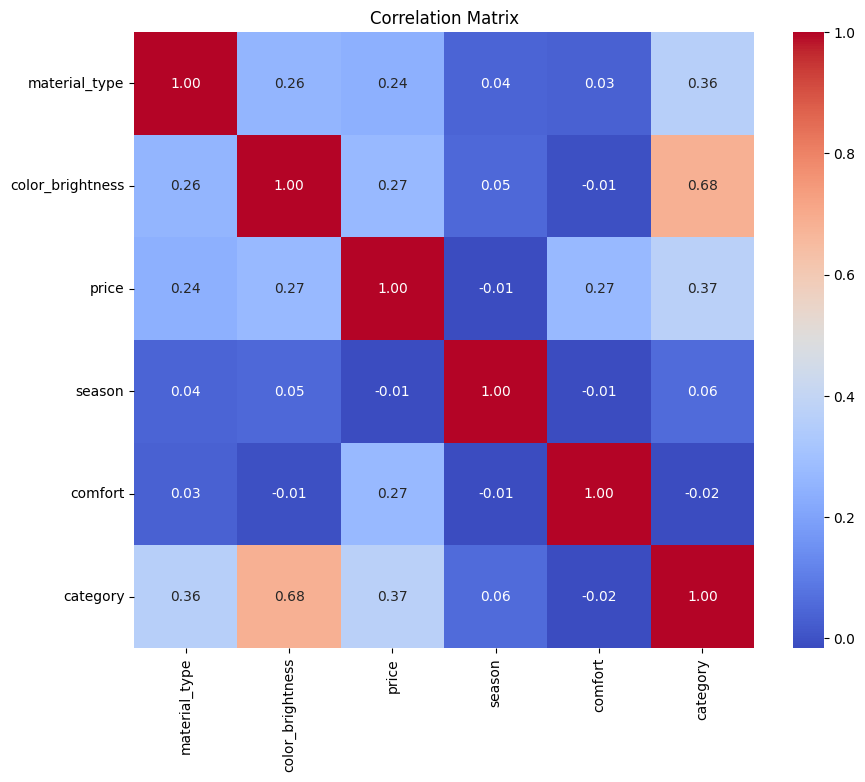

In [130]:
# Checking features correlation

correlation_matrix = fashion_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [132]:
# dividing the dataset into Train, Validation, and test sets

X = fashion_df.drop(columns=["category"])
y = fashion_df["category"] # Target

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


# one-hot encoding for the risk categories
y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=5)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=5)


#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```


> <img src="https://drive.google.com/uc?export=view&id=1_fhKyOFb7DFke_6q1kpm73ZXHQf_81fe" alt="Model Architecture" width="500"/>





#Task: Define a function that creates models without and With specified Optimization techniques


In [133]:
# Define the model
def define_model(optimizer="adam", regularization=None, early_stopping=False, dropout_rate=0.0, learning_rate=0.001, num_hidden_layers=50):
    model = Sequential()

    # Input layer
    model.add(Dense(32, kernel_initializer=he_normal(), activation='relu', input_shape=(X_train.shape[1],)))



    # Hidden layers
    for _ in range(num_hidden_layers):
        model.add(Dense(128, kernel_initializer=he_normal(), activation="relu"))

        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(5, activation="softmax"))

    # Set optimizer
    if optimizer == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Compile the model
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model


In [134]:
# Plot loss curve
def loss_curve_plot(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [135]:
# Evaluate the model
def evaluate_model(model, X_test, y_test, is_nn=False):
    if is_nn:
        y_pred_probs = model.predict(X_test)  # Get predicted probabilities
        y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class indices
    else:
        y_pred = model.predict(X_test)

    # Convert y_test to class indices if it's one-hot encoded
    if y_test.ndim == 2 and y_test.shape[1] > 1:  # Check if y_test is one-hot encoded
        y_test = np.argmax(y_test, axis=1)  # Convert to class indices

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy, precision, recall, f1, cm

# Task: Print out the Final Model Accuracy and plot the Loss curve

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4107 - loss: 1.4775 - val_accuracy: 0.6780 - val_loss: 0.9916
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6807 - loss: 0.9218 - val_accuracy: 0.7200 - val_loss: 0.7435
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7206 - loss: 0.7277 - val_accuracy: 0.7465 - val_loss: 0.6714
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7424 - loss: 0.6609 - val_accuracy: 0.7655 - val_loss: 0.6239
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7586 - loss: 0.6197 - val_accuracy: 0.7730 - val_loss: 0.5922
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7604 - loss: 0.6141 - val_accuracy: 0.7865 - val_loss: 0.5693
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7652 - loss: 0.6084 - val_accuracy: 0.7810 - val_loss: 0.5782
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7768 - loss: 0.5694 - val_accuracy: 0.

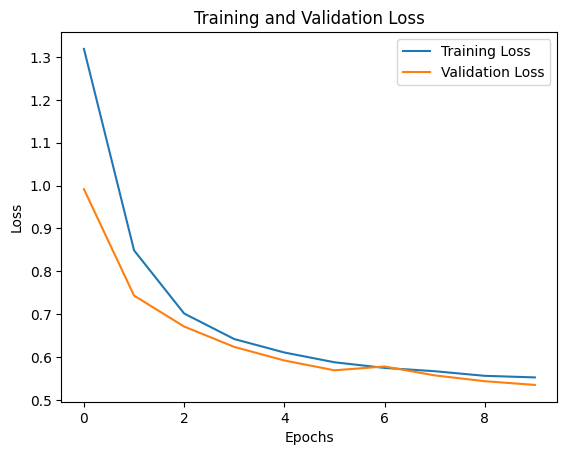

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Confusion Matrix:
[[364   0  21   0   9]
 [  3 345  40  37  25]
 [ 22  36 266   0  61]
 [  0  34  10 312  26]
 [  4  21  46  12 306]]


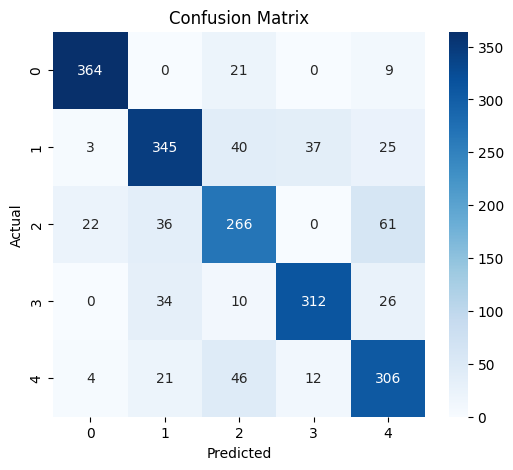


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       394
           1       0.79      0.77      0.78       450
           2       0.69      0.69      0.69       385
           3       0.86      0.82      0.84       382
           4       0.72      0.79      0.75       389

    accuracy                           0.80      2000
   macro avg       0.80      0.80      0.80      2000
weighted avg       0.80      0.80      0.80      2000



(0.7965,
 0.7986554793078866,
 0.7965,
 0.7970874978286656,
 array([[364,   0,  21,   0,   9],
        [  3, 345,  40,  37,  25],
        [ 22,  36, 266,   0,  61],
        [  0,  34,  10, 312,  26],
        [  4,  21,  46,  12, 306]]))

In [136]:
# The Basic Neural Network
def define_basic_model():
    """
    Defines a basic neural network model without any optimization techniques.

    Returns:
        model: Compiled Keras model.
    """

    model_basic = tf.keras.models.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile the model with default settings (no optimizer or learning rate specified)
    model_basic.compile(loss='categorical_crossentropy', metrics=['accuracy'])

    return model_basic

# Create and train the model
model_1 = define_basic_model()
history_basic = model_1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=1)

loss_curve_plot(history_basic)
evaluate_model(model_1, X_test, y_test, is_nn=True)

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.3058 - loss: 1.4679 - val_accuracy: 0.5150 - val_loss: 1.1214
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5904 - loss: 1.0228 - val_accuracy: 0.6650 - val_loss: 0.7908
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6536 - loss: 0.8711 - val_accuracy: 0.7195 - val_loss: 0.7337
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7275 - loss: 0.7387 - val_accuracy: 0.7490 - val_loss: 0.6833
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7265 - loss: 0.7179 - val_accuracy: 0.7330 - val_loss: 0.7057
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7582 - loss: 0.6671 - val_accuracy: 0.6760 - val_loss: 0.7784
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7534 - loss: 0.6610 - val_accuracy: 0.7240 - val_loss: 0.7720
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7495 - loss: 0.6676 -

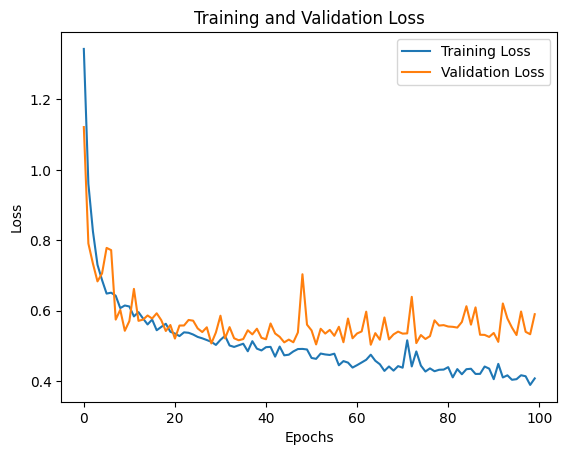

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
[[351   4  17   0  22]
 [  1 348  38  21  42]
 [ 17  22 256   0  90]
 [  0  28   7 307  40]
 [  2   9  30  11 337]]


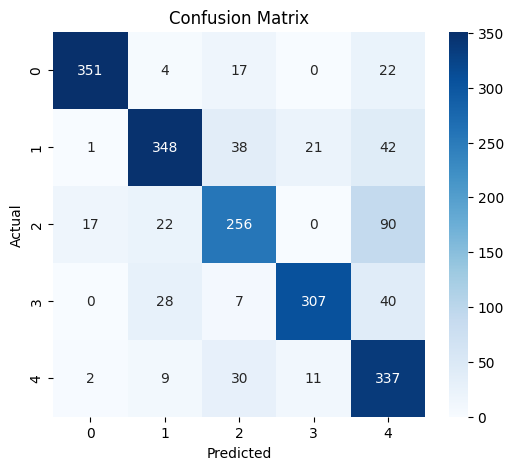


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92       394
           1       0.85      0.77      0.81       450
           2       0.74      0.66      0.70       385
           3       0.91      0.80      0.85       382
           4       0.63      0.87      0.73       389

    accuracy                           0.80      2000
   macro avg       0.81      0.80      0.80      2000
weighted avg       0.81      0.80      0.80      2000



(0.7995,
 0.8149104360372065,
 0.7995,
 0.8022661600084914,
 array([[351,   4,  17,   0,  22],
        [  1, 348,  38,  21,  42],
        [ 17,  22, 256,   0,  90],
        [  0,  28,   7, 307,  40],
        [  2,   9,  30,  11, 337]]))

In [137]:
# The Optimized Neural Network 1

model_2 = define_model(optimizer="adam", dropout_rate=0.0, learning_rate=0.0001, num_hidden_layers=50)
# model_2.summary()
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_2 = model_2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)
loss_curve_plot(history_2)

#evaluting model
evaluate_model(model_2, X_test, y_test, is_nn=True)


Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.2315 - loss: 1.6094 - val_accuracy: 0.3320 - val_loss: 1.5051
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3805 - loss: 1.4296 - val_accuracy: 0.3690 - val_loss: 1.4509
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4602 - loss: 1.2901 - val_accuracy: 0.3290 - val_loss: 1.4945
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5275 - loss: 1.1752 - val_accuracy: 0.5865 - val_loss: 1.1100
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5764 - loss: 1.0780 - val_accuracy: 0.6900 - val_loss: 0.8516
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.6316 - loss: 0.9324 - val_accuracy: 0.6955 - val_loss: 0.8380
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6322 - loss: 0.9077 - val_accuracy: 0.6810 - val_loss: 0.7881
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6767 - loss: 0.8064 - val_ac

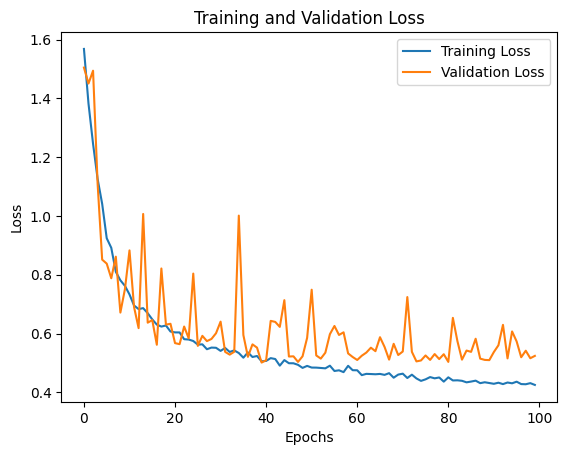

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Confusion Matrix:
[[365   0  18   0  11]
 [  1 316  50  36  47]
 [ 22  17 279   1  66]
 [  0  18   7 318  39]
 [  8   6  36   8 331]]


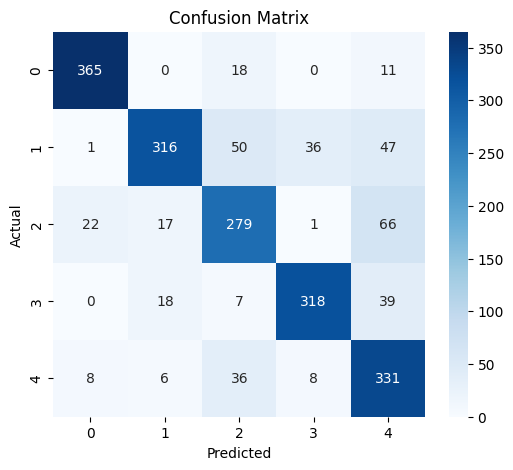


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       394
           1       0.89      0.70      0.78       450
           2       0.72      0.72      0.72       385
           3       0.88      0.83      0.85       382
           4       0.67      0.85      0.75       389

    accuracy                           0.80      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.82      0.80      0.81      2000



(0.8045,
 0.8160946736988814,
 0.8045,
 0.8057211187290831,
 array([[365,   0,  18,   0,  11],
        [  1, 316,  50,  36,  47],
        [ 22,  17, 279,   1,  66],
        [  0,  18,   7, 318,  39],
        [  8,   6,  36,   8, 331]]))

In [138]:
# The Optimized Neural Network 2
model_3 = define_model(optimizer="sgd", dropout_rate=0.0, learning_rate=0.0005, num_hidden_layers=50)
# model_3.summary()
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history_3 = model_3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, verbose=1)
loss_curve_plot(history_3)

#Evaluating model
evaluate_model(model_3, X_test, y_test, is_nn=True)


Confusion Matrix:
[[361   0  29   0   4]
 [  1 345  51  31  22]
 [ 34  58 194   0  99]
 [  0  32  10 307  33]
 [  2  26  58  13 290]]


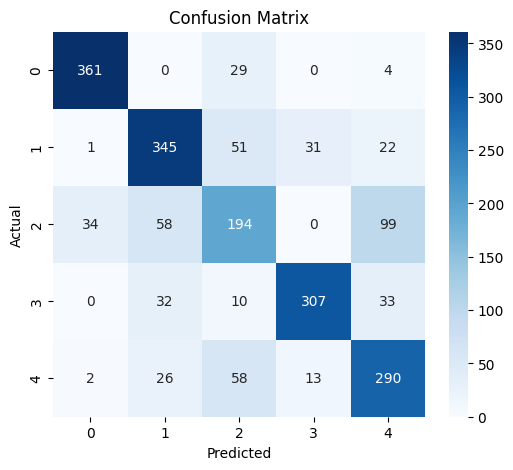


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.91       394
           1       0.75      0.77      0.76       450
           2       0.57      0.50      0.53       385
           3       0.87      0.80      0.84       382
           4       0.65      0.75      0.69       389

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



(0.7485,
 0.7492267819343751,
 0.7485,
 0.7475135713386071,
 array([[361,   0,  29,   0,   4],
        [  1, 345,  51,  31,  22],
        [ 34,  58, 194,   0,  99],
        [  0,  32,  10, 307,  33],
        [  2,  26,  58,  13, 290]]))

In [139]:
#Logistic Regression with Hyperparameter Tuning
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear", "lbfgs"],
    "max_iter": [100, 200, 300]
}
log_reg = LogisticRegression()
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring="accuracy", n_jobs=-1)

# Convert y_train back to a 1D array for Logistic Regression
y_train_1d = np.argmax(y_train, axis=1)

grid_search.fit(X_train, y_train_1d)
best_log_reg = grid_search.best_estimator_
best_log_reg.fit(X_train, y_train_1d)
evaluate_model(best_log_reg, X_test, y_test, is_nn=False)

In [140]:
# TODO: Train and evaluate XGBoost with Hyperparameter Tuning
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Convert y_train back to a 1D array for XGBoost
y_train_1d = np.argmax(y_train, axis=1)

# Define the parameter grid for hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric="mlogloss")

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(xgb_classifier, param_grid_xgb, scoring="accuracy", cv=5, n_jobs=-1, verbose=1)

# Fit the model with hyperparameter tuning
grid_search_xgb.fit(X_train, y_train_1d)

# Get the best estimator
best_xgb = grid_search_xgb.best_estimator_

# Train the best model on the entire training set
best_xgb.fit(X_train, y_train_1d)

# Evaluate the model
y_pred = best_xgb.predict(X_test)  # Get predictions

# Convert y_test to class indices if it's one-hot encoded
if y_test.ndim == 2 and y_test.shape[1] > 1:  # Check if y_test is one-hot encoded
    y_test_1d = np.argmax(y_test, axis=1)  # Convert to class indices
else:
    y_test_1d = y_test

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_1d, y_pred)
precision = precision_score(y_test_1d, y_pred, average="weighted")
recall = recall_score(y_test_1d, y_pred, average="weighted")
f1 = f1_score(y_test_1d, y_pred, average="weighted")

# Print the results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Print the confusion matrix
cm = confusion_matrix(y_test_1d, y_pred)
print("Confusion Matrix:")
print(cm)

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_1d, y_pred))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Accuracy: 0.838
Precision: 0.8423295779738467
Recall: 0.838
F1 Score: 0.8388080680229826
Confusion Matrix:
[[373   0  15   0   6]
 [  0 388  27  12  23]
 [ 17  27 281   0  60]
 [  0  38   3 315  26]
 [  4  16  43   7 319]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       394
           1       0.83      0.86      0.84       450
           2       0.76      0.73      0.75       385
           3       0.94      0.82      0.88       382
           4       0.74      0.82      0.78       389

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [107]:
# saving 'best_xgb', the best model based with  accuracy scores of 0.85
best_model = best_xgb

# Save the model  using joblib.dump
joblib.dump(best_model, "best_model.pkl")



['best_model.pkl']

In [118]:
def make_predictions(model_path, X):

   # Load the model using joblib.load
    model = joblib.load(model_path)

    # Make predictions
    predictions = model.predict(X)

    return predictions
    predictions = model.predict(X)

In [121]:

# Define a dictionary to map category numbers to names
category_mapping = {
    0: "Casual",
    1: "Formal",
    2: "Sportswear",
    3: "Partywear",
    4: "Traditional"
}

def make_predictions(model_path, X):
    """
    Makes predictions using a saved model.

    Args:
        model_path (str): Path to the saved model file.
        X (array-like): Input data for prediction.

    Returns:
        array-like: Predicted categories.
    """
    # Load the model using joblib.load
    model = joblib.load(model_path)

    # Make predictions
    predictions = model.predict(X)

    # Get the predicted category names using category_mapping
    predicted_categories = [category_mapping[prediction] for prediction in predictions]

    return predicted_categories

# Load the model
model_path = "best_model.pkl"

# Prepare the input data
X_new = [[0.5, 0.2, 0.3, 0, 0]]


# Initialize and fit the StandardScaler using your training data (X_train)
scaler = StandardScaler()
scaler.fit(X)

# Transform the new data using the fitted scaler
X_new = scaler.transform(X_new)

# Make predictions
predicted_categories = make_predictions(model_path, X_new)

# Print the predicted category
print(predicted_categories)

['Casual']


Congratulations!!
